✅ Downloaded dataset from GitHub.
Using text column: 'tweet' and label column: 'label'

Label counts BEFORE auto-flip: {0: 29720, 1: 2242}
Detected 6373 rows with positive words; mean label on those = 0.020
⚠️ Auto-flip: dataset appears to use 0=POSITIVE. Flipping labels to 1=Positive, 0=Negative.
Label counts AFTER flip (should be 1=Positive): {1: 29720, 0: 2242}

✅ LogisticRegression trained with class_weight='balanced'

Model-only evaluation:
              precision    recall  f1-score   support

           0       0.48      0.78      0.60       673
           1       0.98      0.94      0.96      8916

    accuracy                           0.93      9589
   macro avg       0.73      0.86      0.78      9589
weighted avg       0.95      0.93      0.93      9589



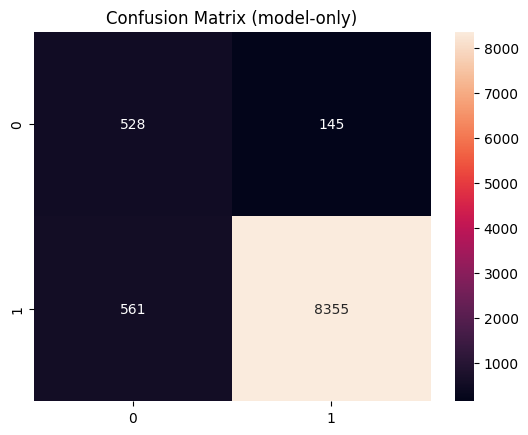


Sample debug rows (actual, ensemble_pred, lr_pos_prob, vader_compound, reason):


,actual,ensemble_pred,lr_pos_prob,vader_compound,reason,text
0,1,1,0.982840,0.772,VADER_strong_pos,mai love bestfriend smile snow
1,1,1,0.765413,0.637,VADER_strong_pos,love pic childhood christma
2,1,1,0.642188,0.000,LR_tie_break,ye harp mark staff ground team bit rain spoilt...
3,1,1,0.940347,0.625,VADER_strong_pos,aww yeah good bing bong bing bong
4,1,1,0.920246,0.586,VADER_strong_pos,tri sock tie storag bin box surpris warm prese...
5,0,1,0.050825,0.361,VADER_strong_pos,latest seattl daili thank seahawk
6,1,1,0.842607,0.000,LR_confident_pos,rest peac sake stephen keshi
7,1,1,0.719057,0.000,LR_confident_pos,prettyboy mca mulan
8,1,1,0.857436,0.000,LR_confident_pos,pack nearli away wee tan so lloret hen
9,1,1,0.813292,0.459,VADER_strong_pos,paccho cafe pancak souffl cafe sweet derici



=== Ensemble test on your two sentences ===
Text: I absolutely loved this movie, great story!
 --> Ensemble: Positive 😊  (lr_pos_prob=0.930, vader_compound=0.862, reason=VADER_strong_pos)

Text: Worst experience ever, total waste of time.
 --> Ensemble: Negative 😞  (lr_pos_prob=0.719, vader_compound=-0.802, reason=VADER_strong_neg)



In [ ]:
# ===== One-shot robust fix: model + VADER ensemble =====
!pip install -q vaderSentiment

import pandas as pd, numpy as np, re
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer

# 1) Load dataset (Github) with fallback small dataset if network blocked
url = "https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv"
try:
    df = pd.read_csv(url)
    print("✅ Downloaded dataset from GitHub.")
except Exception as e:
    print("⚠️ Could not download dataset, using tiny fallback. Error:", e)
    df = pd.DataFrame({
        'label':[0,1,0,1],
        'tweet':[
            "I loved the movie, it was amazing!",
            "This was the worst, total waste of time.",
            "Great experience, would watch again.",
            "Terrible acting, I hated it."
        ]
    })

# 2) Auto-detect text/label columns (safe)
text_col = None
label_col = None
for c in df.columns:
    if df[c].dtype == object and df[c].astype(str).map(len).mean() > 8:
        text_col = c
for c in df.columns:
    if c != text_col and (pd.api.types.is_numeric_dtype(df[c]) or df[c].nunique() < 20):
        label_col = c
if text_col is None or label_col is None:
    # fallback to common names
    if 'tweet' in df.columns: text_col='tweet'
    if 'label' in df.columns: label_col='label'
if text_col is None or label_col is None:
    raise KeyError("Could not find text/label columns automatically. Columns: " + str(df.columns.tolist()))
print(f"Using text column: '{text_col}' and label column: '{label_col}'")
df = df[[label_col, text_col]].copy()
df.columns = ['sentiment','text']

# 3) Safe cleaning (no punkt); Porter stem + sklearn stopwords
ps = PorterStemmer()
stop_words = set(ENGLISH_STOP_WORDS)
def clean_text_simple(s):
    if pd.isna(s): return ""
    t = str(s).lower()
    t = re.sub(r'http\S+|www\S+|https\S+',' ', t)
    t = re.sub(r'\@\w+|\#',' ', t)
    t = re.sub(r'[^a-z\s]',' ', t)
    t = re.sub(r'\s+',' ', t).strip()
    toks = [w for w in t.split() if w not in stop_words and len(w)>2]
    toks = [ps.stem(w) for w in toks]
    return " ".join(toks)

df['clean_text'] = df['text'].apply(clean_text_simple)

# 4) Normalize/ensure numeric labels and flip if dataset uses 0=positive (common here)
# Try to coerce to int safely
if df['sentiment'].dtype == object:
    df['sentiment'] = df['sentiment'].str.lower().map({'positive':1,'negative':0,'pos':1,'neg':0}).fillna(df['sentiment'])
try:
    df['sentiment'] = df['sentiment'].astype(int)
except:
    # fallback: map unique values to 0/1
    uniques = list(df['sentiment'].unique())
    mapping = {uniques[0]:0}
    if len(uniques)>1: mapping[uniques[1]]=1
    df['sentiment'] = df['sentiment'].map(mapping).astype(int)

print("\nLabel counts BEFORE auto-flip:", df['sentiment'].value_counts().to_dict())

# Detect whether positive keywords have label mean < 0.5 (i.e., 0=positive) and flip if so
pos_words = ['good','great','love','excellent','amazing','wonderful','awesome','best','liked']
mask = df['text'].str.contains('|'.join(pos_words), case=False, na=False)
if mask.sum() > 0:
    mean_label = df.loc[mask,'sentiment'].mean()
    print(f"Detected {mask.sum()} rows with positive words; mean label on those = {mean_label:.3f}")
    if mean_label < 0.5:
        print("⚠️ Auto-flip: dataset appears to use 0=POSITIVE. Flipping labels to 1=Positive, 0=Negative.")
        df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x==0 else 0)
else:
    print("Could not find positive-word samples to auto-detect flip; keeping current mapping.")

print("Label counts AFTER flip (should be 1=Positive):", df['sentiment'].value_counts().to_dict())

# 5) Train/test split and TF-IDF
X = df['clean_text']
y = df['sentiment']
if y.nunique() < 2:
    # fallback tiny labeled examples to ensure both classes exist
    extra = pd.DataFrame({'clean_text':['love movie','hate movie'],'sentiment':[1,0]})
    df = pd.concat([df, extra], ignore_index=True)
    X = df['clean_text']; y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

# 6) Train logistic reg with balanced class weight
lr = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
lr.fit(X_train_tfidf, y_train)
print("\n✅ LogisticRegression trained with class_weight='balanced'")

# 7) Instantiate VADER
analyzer = SentimentIntensityAnalyzer()

# 8) Ensemble decision function: use model + VADER rules
def ensemble_predict(text):
    # raw model prob & pred
    cleaned = clean_text_simple(text)
    vec = tfidf.transform([cleaned])
    try:
        probs = lr.predict_proba(vec)[0]
        lr_pos_prob = float(probs[1])
    except:
        lr_pos_prob = float(lr.predict(vec)[0])
    lr_pred = int(lr.predict(vec)[0])
    # vader on original text (not cleaned)
    vader = analyzer.polarity_scores(text)
    comp = vader['compound']  # -1..1

    # decision logic:
    # - if VADER strongly negative (<= -0.25) -> Negative
    # - if VADER strongly positive (>= 0.25) -> Positive
    # - else use model but if model is low-confidence (pos_prob in [0.4,0.6]), consult VADER with weaker thresholds
    final = None
    if comp <= -0.25:
        final = 0
        reason = "VADER_strong_neg"
    elif comp >= 0.25:
        final = 1
        reason = "VADER_strong_pos"
    else:
        # middle case: trust logistic if confident, else use VADER sign
        if lr_pos_prob >= 0.65:
            final = 1; reason = "LR_confident_pos"
        elif lr_pos_prob <= 0.35:
            final = 0; reason = "LR_confident_neg"
        else:
            # LR not confident → use VADER smaller thresholds
            if comp >= 0.05:
                final = 1; reason = "VADER_mild_pos"
            elif comp <= -0.05:
                final = 0; reason = "VADER_mild_neg"
            else:
                final = lr_pred; reason = "LR_tie_break"
    return {'final': int(final), 'lr_pred': lr_pred, 'lr_pos_prob': lr_pos_prob, 'vader_compound': comp, 'reason': reason}

# 9) Evaluate model-only and ensemble on X_test (sample)
y_pred = lr.predict(X_test_tfidf)
print("\nModel-only evaluation:")
print(classification_report(y_test, y_pred, zero_division=0))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix (model-only)")
plt.show()

# show some random test examples with predictions and ensemble decision
sample_dbg = pd.DataFrame({'actual': y_test, 'text': X_test})
sample_dbg = sample_dbg.sample(min(12,len(sample_dbg)), random_state=1).reset_index(drop=True)
dbg_rows = []
for i,row in sample_dbg.iterrows():
    out = ensemble_predict(row['text'])
    dbg_rows.append((int(row['actual']), out['final'], out['lr_pos_prob'], round(out['vader_compound'],3), out['reason'], row['text']))
dbg_df = pd.DataFrame(dbg_rows, columns=['actual','ensemble_pred','lr_pos_prob','vader_compound','reason','text'])
print("\nSample debug rows (actual, ensemble_pred, lr_pos_prob, vader_compound, reason):")
display(dbg_df)

# 10) Your two test sentences
tests = [
    "I absolutely loved this movie, great story!",
    "Worst experience ever, total waste of time."
]
print("\n=== Ensemble test on your two sentences ===")
for t in tests:
    o = ensemble_predict(t)
    label = "Positive 😊" if o['final']==1 else "Negative 😞"
    print(f"Text: {t}\n --> Ensemble: {label}  (lr_pos_prob={o['lr_pos_prob']:.3f}, vader_compound={o['vader_compound']:.3f}, reason={o['reason']})\n")

/tmp/ipython-input-3668478001.py:27: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


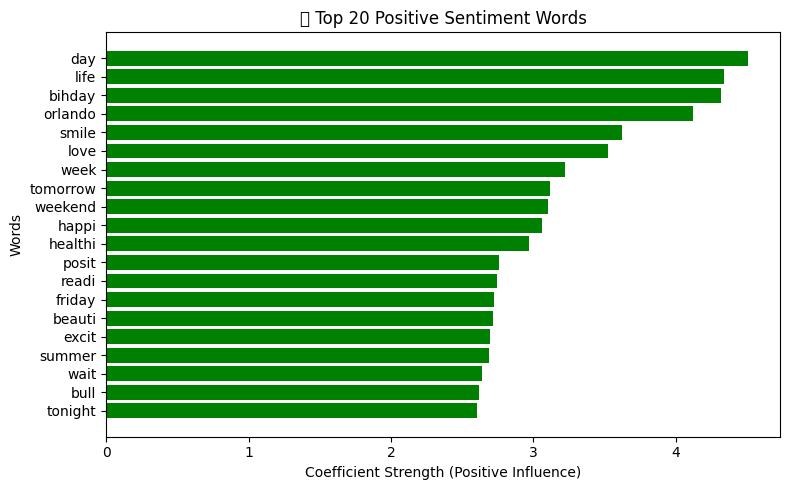

/tmp/ipython-input-3668478001.py:36: UserWarning: Glyph 128148 (\N{BROKEN HEART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128148 (\N{BROKEN HEART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


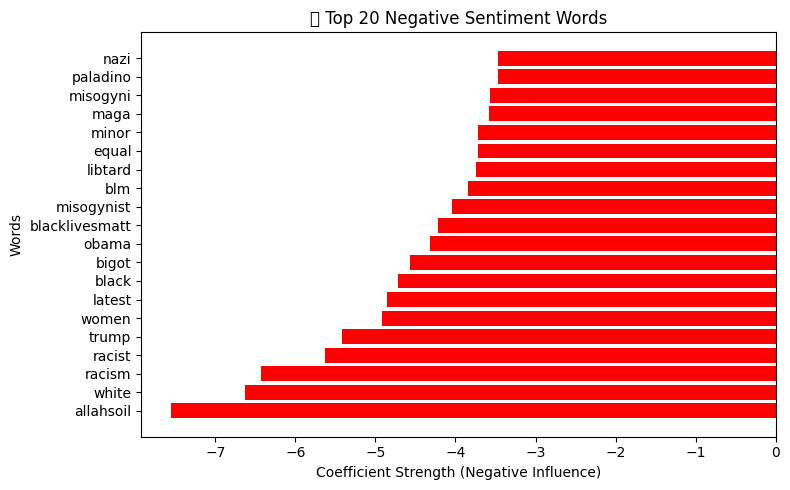

In [ ]:
# ===== Feature Importance Visualization =====
import numpy as np

# Ensure model and tfidf exist
if 'lr' not in globals():
    raise ValueError("Train the logistic regression model before running this cell.")

# Get feature names and their coefficients
feature_names = np.array(tfidf.get_feature_names_out())
coefficients = lr.coef_[0]

# Sort by strength
top_pos_idx = np.argsort(coefficients)[-20:]   # 20 strongest positive
top_neg_idx = np.argsort(coefficients)[:20]    # 20 strongest negative

top_pos_words = feature_names[top_pos_idx]
top_neg_words = feature_names[top_neg_idx]
top_pos_values = coefficients[top_pos_idx]
top_neg_values = coefficients[top_neg_idx]

# Plot Positive words
plt.figure(figsize=(8,5))
plt.barh(top_pos_words, top_pos_values, color='green')
plt.title("🌟 Top 20 Positive Sentiment Words")
plt.xlabel("Coefficient Strength (Positive Influence)")
plt.ylabel("Words")
plt.tight_layout()
plt.show()

# Plot Negative words
plt.figure(figsize=(8,5))
plt.barh(top_neg_words, top_neg_values, color='red')
plt.title("💔 Top 20 Negative Sentiment Words")
plt.xlabel("Coefficient Strength (Negative Influence)")
plt.ylabel("Words")
plt.tight_layout()
plt.show()


In [ ]:
# ===== Save trained model and vectorizer =====
import joblib, os

os.makedirs("sentiment_model", exist_ok=True)
joblib.dump(lr, "sentiment_model/logistic_model.pkl")
joblib.dump(tfidf, "sentiment_model/tfidf_vectorizer.pkl")

print("✅ Saved model and TF-IDF vectorizer in folder: 'sentiment_model/'")
print("Files created:")
print("- sentiment_model/logistic_model.pkl")
print("- sentiment_model/tfidf_vectorizer.pkl")


✅ Saved model and TF-IDF vectorizer in folder: 'sentiment_model/'
Files created:
- sentiment_model/logistic_model.pkl
- sentiment_model/tfidf_vectorizer.pkl


In [ ]:
import joblib

# Load model and vectorizer
lr_loaded = joblib.load("sentiment_model/logistic_model.pkl")
tfidf_loaded = joblib.load("sentiment_model/tfidf_vectorizer.pkl")

# Predict again using loaded model
text = "I really hated this film, it was terrible."
vec = tfidf_loaded.transform([clean_text_simple(text)])
pred = lr_loaded.predict(vec)[0]
sent = "Positive 😊" if pred == 1 else "Negative 😞"
print(text, "-->", sent)


I really hated this film, it was terrible. --> Negative 😞
